In [1]:
! pip3 install tensorflow-gpu==2.0.0-rc1

In [0]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [0]:
# --------------------------------------------------------------------------------------------------------------
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [0]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B', 'V'}
        self.mask_type = mask_type

        self.filters = filters

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        kernel_h, kernel_w = self.kernel_size

        self.kernel = self.add_weight("kernel",
                                      shape=(kernel_h,
                                             kernel_w,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        if self.mask_type == 'V':
            mask[kernel_h // 2:, :, :, :] = 0.
        else:
            mask[kernel_h // 2, kernel_w // 2 + (self.mask_type == 'B'):, :, :] = 0.
            mask[kernel_h // 2 + 1:, :, :] = 0.

        self.mask = tf.constant(mask,
                                dtype=tf.float32,
                                name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

In [0]:
class GatedBlock(tf.keras.Model):
    """"""

    def __init__(self, n_filters):
        super(GatedBlock, self).__init__(name='')

        self.vertical_conv = MaskedConv2D(mask_type='V', filters = 2 * n_filters, kernel_size=3)
        self.horizontal_conv = MaskedConv2D(mask_type='B', filters = 2 * n_filters, kernel_size=(1, 3))
        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * n_filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=n_filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v, h = tf.split(input_tensor, 2, axis=-1)
        horizontal_preactivation = self.horizontal_conv(h)  # 1xN
        vertical_preactivation = self.vertical_conv(v)  # NxN
        v_to_h = self.v_to_h_conv(vertical_preactivation)  # 1x1
        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        h_activated = self._gate(horizontal_preactivation)

        h_preres = self.horizontal_output(h_activated)

        h_out = h + h_preres

        output = tf.concat((v_out, h_out), axis=-1)
        return output

In [0]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [0]:
def sample_from(distribution):
    """Sample random values from distribution"""
    batch_size, bins = distribution.shape
    return np.array([np.random.choice(bins, p=distr) for distr in distribution])



In [0]:
# --------------------------------------------------------------------------------------------------------------
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, 1)
x_test = x_test.reshape(x_test.shape[0], height, width, 1)


In [0]:
# --------------------------------------------------------------------------------------------------------------
# Quantise the input data in q levels
q_levels = 256
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

In [10]:
# --------------------------------------------------------------------------------------------------------------
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# --------------------------------------------------------------------------------------------------------------
# Create PixelCNN model
# https://github.com/RishabGoel/PixelCNN/blob/master/pixel_cnn.py
# https://github.com/jonathanventura/pixelcnn/blob/master/pixelcnn.py

inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(7):
    x = GatedBlock(64)(x)

v, h = tf.split(x, 2, axis=-1)

x = keras.layers.Activation(activation='relu')(h)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)


In [0]:
# --------------------------------------------------------------------------------------------------------------
# Prepare optimizer and loss function
lr_decay = 0.9995
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


In [0]:
# --------------------------------------------------------------------------------------------------------------
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In [14]:
# --------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 30
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))


EPOCH   0: ITER    0/ 469 TIME: 5.23 LOSS: 5.5463
EPOCH   0: ITER  100/ 469 TIME: 0.24 LOSS: 0.8595
EPOCH   0: ITER  200/ 469 TIME: 0.24 LOSS: 0.8490
EPOCH   0: ITER  300/ 469 TIME: 0.25 LOSS: 0.7895
EPOCH   0: ITER  400/ 469 TIME: 0.26 LOSS: 0.8266
EPOCH   0: TIME: 122.50 ETA: 3674.90
EPOCH   1: ITER    0/ 469 TIME: 0.03 LOSS: 0.8536
EPOCH   1: ITER  100/ 469 TIME: 0.25 LOSS: 0.8012
EPOCH   1: ITER  200/ 469 TIME: 0.25 LOSS: 0.8190
EPOCH   1: ITER  300/ 469 TIME: 0.25 LOSS: 0.7893
EPOCH   1: ITER  400/ 469 TIME: 0.24 LOSS: 0.7757
EPOCH   1: TIME: 118.31 ETA: 3430.95
EPOCH   2: ITER    0/ 469 TIME: 0.03 LOSS: 0.8199
EPOCH   2: ITER  100/ 469 TIME: 0.25 LOSS: 0.8040
EPOCH   2: ITER  200/ 469 TIME: 0.25 LOSS: 0.7864
EPOCH   2: ITER  300/ 469 TIME: 0.25 LOSS: 0.8103
EPOCH   2: ITER  400/ 469 TIME: 0.25 LOSS: 0.7584
EPOCH   2: TIME: 118.66 ETA: 3322.50
EPOCH   3: ITER    0/ 469 TIME: 0.03 LOSS: 0.7729
EPOCH   3: ITER  100/ 469 TIME: 0.25 LOSS: 0.8080
EPOCH   3: ITER  200/ 469 TIME: 0.25 LO

In [15]:
# --------------------------------------------------------------------------------------------------------------
# Test
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))



nll : 0.7489756941795349 nats
bits/dim : 0.000955326140535121


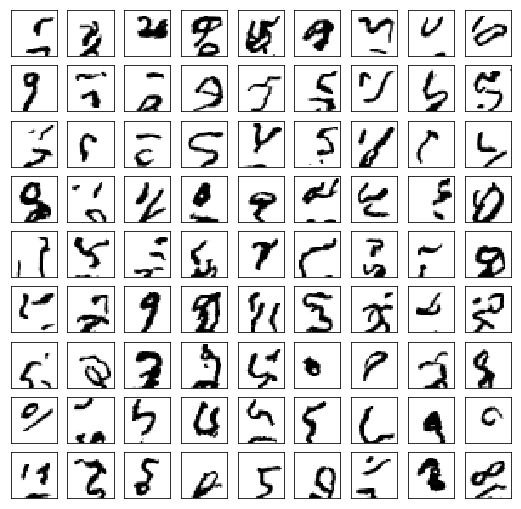

In [16]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = (np.random.rand(100, height, width, n_channel) * 0.01).astype('float32')
for i in range(28):
    for j in range(28):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        probs = tf.nn.softmax(logits)
        next_sample = probs[:, i, j, 0, :]
        samples[:, i, j, 0] = sample_from(next_sample.numpy()) / (q_levels - 1)

fig = plt.figure(figsize=(10, 10))
for x in range(1, 10):
    for y in range(1, 10):
        ax = fig.add_subplot(10, 10, 10 * y + x)
        ax.matshow(samples[10 * y + x, :, :, 0], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
plt.show()


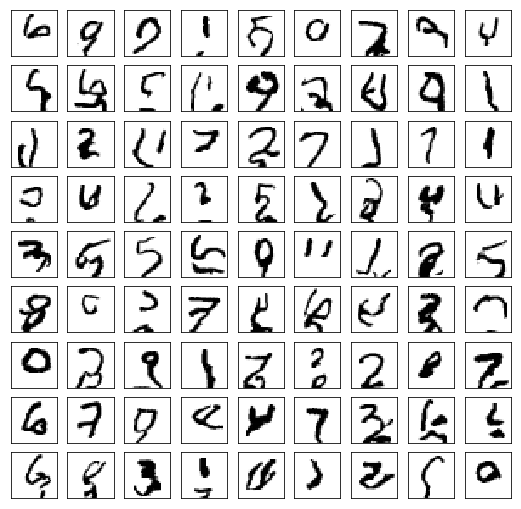

In [17]:
# --------------------------------------------------------------------------------------------------------------
# Filling occluded images
occlude_start_row = 14
num_generated_images = 100
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        probs = tf.nn.softmax(logits)
        next_sample = probs[:, i, j, 0, :]
        samples[:, i, j, 0] = sample_from(next_sample.numpy()) / (q_levels - 1)

fig = plt.figure(figsize=(10, 10))
for x in range(1, 10):
    for y in range(1, 10):
        ax = fig.add_subplot(10, 10, 10 * y + x)
        ax.matshow(samples[10 * y + x, :, :, 0], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
plt.show()
